<a href="https://colab.research.google.com/github/Nerothenerd02/ElderFit_AI_Model/blob/main/ElderFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install humanize


In [ ]:
import zipfile
import os
from tqdm import tqdm
import humanize

# Paths
zip_path = "/content/drive/My Drive/Elderfit_videos/data_sent.zip"
extract_path = "/content/dataset"

# Extract with progress
total_size = 0
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.infolist()
    with tqdm(total=len(file_list), desc="Extracting", unit="file") as pbar:
        for file_info in file_list:
            zip_ref.extract(file_info, extract_path)
            total_size += file_info.file_size
            pbar.set_postfix_str(f"Extracted: {humanize.naturalsize(total_size)}")
            pbar.update(1)

print("✅ Done extracting to local storage.")


Extracting: 100%|██████████| 323890/323890 [15:13<00:00, 354.42file/s, Extracted: 7.3 GB] 

✅ Done extracting to local storage.


In [ ]:
# Optional: Clean up previous clone (if re-running)
!rm -rf ElderFit_AI_Model

# Clone your GitHub repository
!git clone https://github.com/Nerothenerd02/ElderFit_AI_Model.git

# Change directory into the repo
%cd ElderFit_AI_Model

Cloning into 'ElderFit_AI_Model'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 31 (delta 8), reused 31 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 9.04 KiB | 9.04 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/ElderFit_AI_Model


In [ ]:
import zipfile
import os
from tqdm import tqdm
import humanize

# Paths
zip_path = "/content/drive/My Drive/Elderfit_videos/data_sent.zip"
extract_path = "/content/dataset"

# Extract with progress
total_size = 0
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.infolist()
    with tqdm(total=len(file_list), desc="Extracting", unit="file") as pbar:
        for file_info in file_list:
            zip_ref.extract(file_info, extract_path)
            total_size += file_info.file_size
            pbar.set_postfix_str(f"Extracted: {humanize.naturalsize(total_size)}")
            pbar.update(1)

print("✅ Done extracting to local storage.")


Extracting: 100%|██████████| 323890/323890 [11:34<00:00, 466.52file/s, Extracted: 7.3 GB]

✅ Done extracting to local storage.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os

# Load the MoveNet model from TensorFlow Hub
model_name = "movenet_thunder"  # Options: 'movenet_lightning', 'movenet_thunder'

try:
    if model_name == "movenet_lightning":
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    else:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    print("✅ MoveNet Model Loaded Successfully!")
except Exception as e:
    print(f"❌ ERROR: Failed to load MoveNet model. \n{str(e)}")

# Define the mapping of keypoints to body parts
KEYPOINT_DICT = {
    'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
    'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
    'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
    'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
}

# Define the connections between keypoints to draw lines for visualization
EDGES = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 6), (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)
]

def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    y, x, _ = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0, 255, 0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    y, x, _ = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    for edge in edges:
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        if c1 > confidence_threshold and c2 > confidence_threshold:
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

def movenet(input_image):
    model = module.signatures['serving_default']
    input_image = tf.image.resize_with_pad(input_image, 256, 256)
    input_image = tf.cast(input_image, dtype=tf.int32)
    outputs = model(input_image)
    keypoints = outputs['output_0'].numpy()
    return keypoints

def process_video(video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    os.makedirs(output_dir, exist_ok=True)
    frame_number = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        input_image = tf.convert_to_tensor([frame], dtype=tf.uint8)
        keypoints = movenet(input_image)

        draw_connections(frame, keypoints, EDGES)
        draw_keypoints(frame, keypoints)

        output_path = os.path.join(output_dir, f"frame_{frame_number:04d}.jpg")
        cv2.imwrite(output_path, frame)
        frame_number += 1

    cap.release()

# ✅ Define base directory dynamically
BASE_DIR = r"/content/dataset/data_sent"
PROCESSED_ONE_DIR = os.path.join(DATA_DIR, "processed_one")
PROCESSED_TWO_DIR = os.path.join(DATA_DIR, "processed_two")


# ✅ Define paths dynamically
video_path = os.path.join(PROCESSED_ONE_DIR, "yoga", EXERCISE, FORM, VIDEO_ID, "frame_0010.jpg")
output_dir = os.path.join(PROCESSED_TWO_DIR, "yoga", EXERCISE, FORM, VIDEO_ID)

# ✅ Print paths to verify
print(f"🎥 Video Path: {video_path}")
print(f"📂 Output Directory: {output_dir}")

# ✅ Run annotation test
process_video(video_path, output_dir)


Keypoints (x, y, confidence):
[[0.49861336 0.3438886  0.32058623]
 [0.48535562 0.3375461  0.51084447]
 [0.5106024  0.32535118 0.5640635 ]
 [0.48086128 0.34828    0.4458474 ]
 [0.5359135  0.32733604 0.6258159 ]
 [0.41430464 0.37143132 0.57698226]
 [0.602919   0.36727256 0.53235906]
 [0.3871742  0.28613728 0.652958  ]
 [0.59779674 0.28076565 0.8483111 ]
 [0.45017204 0.16878495 0.6497968 ]
 [0.5371182  0.16164172 0.6928953 ]
 [0.46656686 0.54453164 0.66127914]
 [0.56421506 0.5470667  0.6362291 ]
 [0.48868918 0.68221647 0.705514  ]
 [0.52296436 0.6852993  0.26644295]
 [0.5055571  0.72810495 0.48254615]
 [0.6559334  0.6708288  0.37262386]]


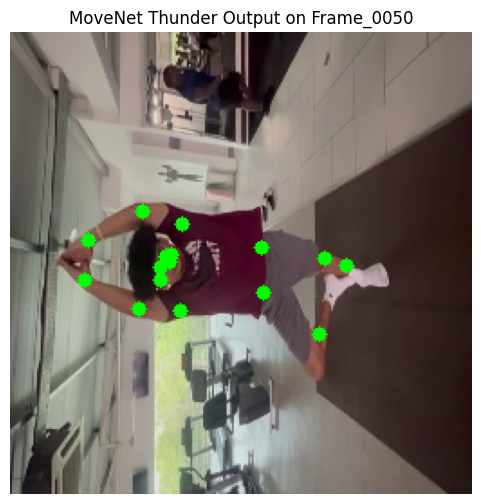

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load MoveNet
model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']

# Path to your test frame
img_path = "/content/dataset/data_sent/processed_one/yoga/tree/correct/68/frame_0050.jpg"

# Load and preprocess image
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img)
input_img = tf.image.resize_with_pad(img, 256, 256)
input_img = tf.expand_dims(input_img, axis=0)
input_img = tf.cast(input_img, dtype=tf.int32)

# Run MoveNet
outputs = movenet(input_img)
keypoints = outputs['output_0'].numpy()[0][0]  # (17, 3)

print("Keypoints (x, y, confidence):")
print(keypoints)

# Optional: Visualize keypoints on the image
def draw_keypoints(image, keypoints, confidence_threshold=0.3):
    h, w, _ = image.shape
    for i in range(17):
        y, x, c = keypoints[i]
        if c > confidence_threshold:
            cv2.circle(image, (int(x * w), int(y * h)), 4, (0, 255, 0), -1)
    return image

# Display original image with keypoints
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
output_img = draw_keypoints(img_rgb.copy(), keypoints)

plt.figure(figsize=(6, 6))
plt.imshow(output_img)
plt.title("MoveNet Thunder Output on Frame_0050")
plt.axis('off')
plt.show()


Keypoints (x, y, confidence):
[[0.49467307 0.3362903  0.4453944 ]
 [0.47630477 0.32660714 0.49646193]
 [0.5070839  0.32104552 0.48511127]
 [0.4479652  0.31966767 0.41582283]
 [0.5216999  0.3098449  0.45503244]
 [0.38649243 0.3635275  0.62973946]
 [0.56899    0.34534514 0.6044246 ]
 [0.38027996 0.28247806 0.8303001 ]
 [0.6042706  0.2874837  0.6466433 ]
 [0.44101602 0.17591207 0.65672565]
 [0.5331769  0.16611838 0.43112466]
 [0.4627313  0.53047514 0.5694773 ]
 [0.57126045 0.51622176 0.63820374]
 [0.48054647 0.6787236  0.4544445 ]
 [0.64916503 0.5703908  0.21016738]
 [0.5149148  0.69785774 0.291203  ]
 [0.64440614 0.6743723  0.3172703 ]]


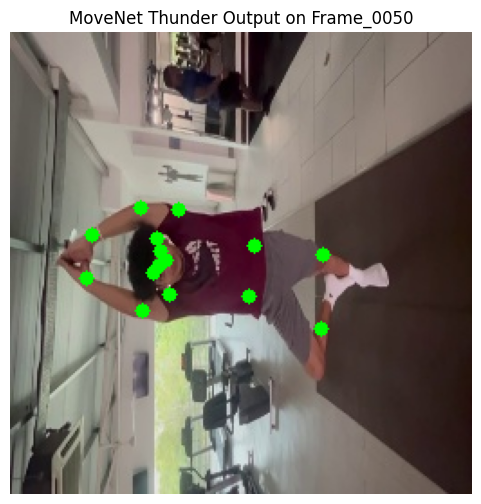

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load MoveNet
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# Path to your test frame
img_path = "/content/dataset/data_sent/processed_one/yoga/tree/correct/68/frame_0050.jpg"

# Load and preprocess image
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img)

# Resize and pad the image to the expected input shape (192, 192)
input_img = tf.image.resize_with_pad(img, 192, 192)

input_img = tf.expand_dims(input_img, axis=0)
input_img = tf.cast(input_img, dtype=tf.int32)

# Run MoveNet
outputs = movenet(input_img)
keypoints = outputs['output_0'].numpy()[0][0]  # (17, 3)

print("Keypoints (x, y, confidence):")
print(keypoints)

# Optional: Visualize keypoints on the image
def draw_keypoints(image, keypoints, confidence_threshold=0.3):
    h, w, _ = image.shape
    for i in range(17):
        y, x, c = keypoints[i]
        if c > confidence_threshold:
            cv2.circle(image, (int(x * w), int(y * h)), 4, (0, 255, 0), -1)
    return image

# Display original image with keypoints
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
output_img = draw_keypoints(img_rgb.copy(), keypoints)

plt.figure(figsize=(6, 6))
plt.imshow(output_img)
plt.title("MoveNet Thunder Output on Frame_0050")
plt.axis('off')
plt.show()


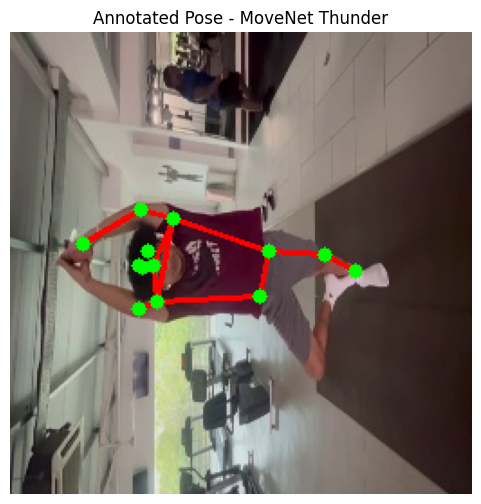

✅ Annotated image saved at: /content/dataset/processed_two/annotated_frame_0050.jpg


In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

# Download the MoveNet Thunder TFLite model if it doesn't exist
model_path = 'lite-model_movenet_singlepose_thunder_3.tflite'
if not os.path.exists(model_path):
    !wget -q -O {model_path} https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite

# Load MoveNet Thunder TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Path to your test frame
img_path = "/content/dataset/data_sent/processed_one/yoga/tree/correct/68/frame_0050.jpg"

# Load image
frame = cv2.imread(img_path)

# Reshape image
img = frame.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 256, 256)
input_image = tf.cast(img, dtype=tf.float32)

# Setup input and output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Make predictions
interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

# Modify keypoints to match frame size
def modify_keypoints(frame, keypoints):
    height, width, *_ = frame.shape
    box_size = max(height, width)
    modified_keypoints = []

    for y, x, confidence in keypoints[0][0]:
        modified_x = int(x * box_size - (box_size - width) / 2)
        modified_y = int(y * box_size - (box_size - height) / 2)
        modified_keypoints.append((modified_y, modified_x, confidence))

    return modified_keypoints

modified_keypoints = modify_keypoints(frame, keypoints_with_scores)

# Draw keypoints
def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    for y, x, confidence in keypoints:
        if confidence > confidence_threshold:
            cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

# Define body part connections
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Draw connections between keypoints
def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]

        if (c1 > confidence_threshold) and (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

# Apply drawing functions
draw_connections(frame, modified_keypoints, EDGES, 0.3)
draw_keypoints(frame, modified_keypoints, 0.3)

# Save and display the output
output_path = "/content/dataset/processed_two/annotated_frame_0050.jpg"
cv2.imwrite(output_path, frame)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Annotated Pose - MoveNet Thunder")
plt.axis('off')
plt.show()

print(f"✅ Annotated image saved at: {output_path}")


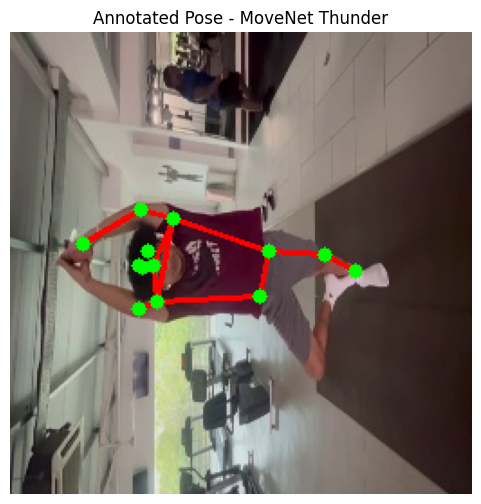

✅ Annotated image saved at: /content/dataset/processed_two/annotated_frame_0050.jpg


In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

# Load MoveNet
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# Path to your test frame
img_path = "/content/dataset/data_sent/processed_one/yoga/tree/correct/68/frame_0050.jpg"

# Load image
frame = cv2.imread(img_path)

# Reshape image
img = frame.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 256, 256)
input_image = tf.cast(img, dtype=tf.float32)

# Setup input and output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Make predictions
interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

# Modify keypoints to match frame size
def modify_keypoints(frame, keypoints):
    height, width, *_ = frame.shape
    box_size = max(height, width)
    modified_keypoints = []

    for y, x, confidence in keypoints[0][0]:
        modified_x = int(x * box_size - (box_size - width) / 2)
        modified_y = int(y * box_size - (box_size - height) / 2)
        modified_keypoints.append((modified_y, modified_x, confidence))

    return modified_keypoints

modified_keypoints = modify_keypoints(frame, keypoints_with_scores)

# Draw keypoints
def draw_keypoints(frame, keypoints, confidence_threshold=0.15):
    for y, x, confidence in keypoints:
        if confidence > confidence_threshold:
            cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

# Define body part connections
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Draw connections between keypoints
def draw_connections(frame, keypoints, edges, confidence_threshold=0.15):
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]

        if (c1 > confidence_threshold) and (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

# Apply drawing functions
draw_connections(frame, modified_keypoints, EDGES, 0.3)
draw_keypoints(frame, modified_keypoints, 0.3)

# Save and display the output
output_path = "/content/dataset/processed_two/annotated_frame_0050.jpg"
cv2.imwrite(output_path, frame)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Annotated Pose - MoveNet Thunder")
plt.axis('off')
plt.show()

print(f"✅ Annotated image saved at: {output_path}")


In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

# Load MoveNet
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# Path to your test frame
img_path = "/content/dataset/data_sent/processed_one/yoga/tree/correct/68/frame_0050.jpg"

# Load image
frame = cv2.imread(img_path)

# Reshape image
img = frame.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 256, 256)
input_image = tf.cast(img, dtype=tf.float32)

# Setup input and output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Make predictions
interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

# Modify keypoints to match frame size
def modify_keypoints(frame, keypoints):
    height, width, *_ = frame.shape
    box_size = max(height, width)
    modified_keypoints = []

    for y, x, confidence in keypoints[0][0]:
        modified_x = int(x * box_size - (box_size - width) / 2)
        modified_y = int(y * box_size - (box_size - height) / 2)
        modified_keypoints.append((modified_y, modified_x, confidence))

    return modified_keypoints

modified_keypoints = modify_keypoints(frame, keypoints_with_scores)

# Draw keypoints
def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    for y, x, confidence in keypoints:
        if confidence > confidence_threshold:
            cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

# Define body part connections
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Draw connections between keypoints
def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]

        if (c1 > confidence_threshold) and (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

# Apply drawing functions
draw_connections(frame, modified_keypoints, EDGES, 0.3)
draw_keypoints(frame, modified_keypoints, 0.3)

# Save and display the output
output_path = "/content/dataset/processed_two/annotated_frame_0050.jpg"
cv2.imwrite(output_path, frame)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Annotated Pose - MoveNet Thunder")
plt.axis('off')
plt.show()

print(f"✅ Annotated image saved at: {output_path}")


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

# Load MoveNet Lightning from TF Hub
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# Path to your test frame
img_path = "/content/dataset/data_sent/processed_one/yoga/tree/correct/68/frame_0050.jpg"
frame = cv2.imread(img_path)

# Resize and preprocess image
# Changed to resize to 192x192 for MoveNet Lightning
img = frame.copy()
img = tf.image.resize_with_pad(tf.convert_to_tensor(img), 192, 192)
input_image = tf.expand_dims(img, axis=0)
input_image = tf.cast(input_image, dtype=tf.int32)

# Run pose estimation
outputs = movenet(input_image)
keypoints = outputs['output_0'].numpy()[0][0]  # shape: (17, 3)

# Map to image size
def modify_keypoints(frame, keypoints):
    height, width, _ = frame.shape
    box_size = max(height, width)
    modified_keypoints = []
    for y, x, confidence in keypoints:
        x = int(x * box_size - (box_size - width) / 2)
        y = int(y * box_size - (box_size - height) / 2)
        modified_keypoints.append((y, x, confidence))
    return modified_keypoints

modified_keypoints = modify_keypoints(frame, keypoints)

# Draw keypoints
def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    for y, x, confidence in keypoints:
        if confidence > confidence_threshold:
            cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

# Define edges
EDGES = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c',
    (0, 5): 'm', (0, 6): 'c', (5, 7): 'm', (7, 9): 'm',
    (6, 8): 'c', (8, 10): 'c', (5, 6): 'y', (5, 11): 'm',
    (6, 12): 'c', (11, 12): 'y', (11, 13): 'm', (13, 15): 'm',
    (12, 14): 'c', (14, 16): 'c'
}

# Draw connections
def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    for edge, _ in edges.items():
        p1, p2 = edge
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]
        if c1 > confidence_threshold and c2 > confidence_threshold:
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Apply draw functions
draw_connections(frame, modified_keypoints, EDGES, 0.15)
draw_keypoints(frame, modified_keypoints, 0.15)

# Save and show result
output_path = "/content/dataset/processed_two/annotated_frame_0050_lightning.jpg"
cv2.imwrite(output_path, frame)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Annotated Pose - MoveNet Lightning (Threshold: 0.15)")
plt.axis('off')
plt.show()

print(f"✅ Annotated image saved at: {output_path}")


AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

# Load MoveNet Lightning from TF Hub
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# Path setup
folder_path = "/content/dataset/data_sent/processed_one/yoga/tree/correct/68"
output_csv = "/content/dataset/processed_two/yoga/tree/correct/68/annotated_keypoints_folder_68.csv"
annotated_img_folder = "/content/dataset/processed_two/yoga/tree/correct/68/annotated_images_68"
os.makedirs(annotated_img_folder, exist_ok=True)

# Keypoint modification
def modify_keypoints(frame, keypoints):
    height, width, *_ = frame.shape
    box_size = max(height, width)
    modified_keypoints = []
    for y, x, confidence in keypoints:
        x = int(x * box_size - (box_size - width) / 2)
        y = int(y * box_size - (box_size - height) / 2)
        modified_keypoints.append((y, x, confidence))
    return modified_keypoints

# Drawing functions
def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    for y, x, confidence in keypoints:
        if confidence > confidence_threshold:
            cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

EDGES = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c',
    (0, 5): 'm', (0, 6): 'c', (5, 7): 'm', (7, 9): 'm',
    (6, 8): 'c', (8, 10): 'c', (5, 6): 'y', (5, 11): 'm',
    (6, 12): 'c', (11, 12): 'y', (11, 13): 'm', (13, 15): 'm',
    (12, 14): 'c', (14, 16): 'c'
}

def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    for edge in edges:
        p1, p2 = edge
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]
        if c1 > confidence_threshold and c2 > confidence_threshold:
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Process frames
keypoints_data = []
frame_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".png"))])

for file in tqdm(frame_files, desc="Annotating frames in folder 68"):
    img_path = os.path.join(folder_path, file)
    frame = cv2.imread(img_path)
    if frame is None:
        continue

    # Preprocess for model
    # Changed to resize to 192x192 for MoveNet Lightning
    img = tf.image.resize_with_pad(tf.convert_to_tensor(frame), 192, 192)
    input_image = tf.expand_dims(img, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)


    # Run model
    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()[0][0]  # (17, 3)

    # Save keypoints
    flat_kps = keypoints.flatten().tolist()
    keypoints_data.append([file] + flat_kps)

    # Annotate and save image (optional)
    modified_keypoints = modify_keypoints(frame, keypoints)
    draw_connections(frame, modified_keypoints, EDGES, 0.15)
    draw_keypoints(frame, modified_keypoints, 0.15)
    annotated_path = os.path.join(annotated_img_folder, file)
    cv2.imwrite(annotated_path, frame)

# Save to CSV
columns = ['filename'] + [f'kp{i}_{axis}' for i in range(17) for axis in ['x', 'y', 'conf']]
df = pd.DataFrame(keypoints_data, columns=columns)
df.to_csv(output_csv, index=False)

print(f"✅ Done! CSV saved to: {output_csv}")
print(f"📸 Annotated images saved to: {annotated_img_folder}")

Annotating frames in folder 68: 100%|██████████| 317/317 [00:12<00:00, 26.31it/s]

✅ Done! CSV saved to: /content/dataset/processed_two/annotated_keypoints_folder_68.csv
📸 Annotated images saved to: /content/dataset/processed_two/yoga/tree/correct/68/annotated_images_68


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os
import pandas as pd
from tqdm import tqdm
import time

# Start timer
start_time = time.time()

# Load MoveNet Lightning
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

# Define workouts
workouts = ["deadlifts", "bird_dog", "chair_squats"]

# Define edges
EDGES = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c',
    (0, 5): 'm', (0, 6): 'c', (5, 7): 'm', (7, 9): 'm',
    (6, 8): 'c', (8, 10): 'c', (5, 6): 'y', (5, 11): 'm',
    (6, 12): 'c', (11, 12): 'y', (11, 13): 'm', (13, 15): 'm',
    (12, 14): 'c', (14, 16): 'c'
}

# Helper functions
def modify_keypoints(frame, keypoints):
    height, width, *_ = frame.shape
    box_size = max(height, width)
    return [(int(y * box_size - (box_size - height) / 2),
             int(x * box_size - (box_size - width) / 2),
             conf) for y, x, conf in keypoints]

def draw_keypoints(frame, keypoints, confidence_threshold=0.3):
    for y, x, confidence in keypoints:
        if confidence > confidence_threshold:
            cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold=0.3):
    for edge in edges:
        p1, p2 = edge
        y1, x1, c1 = keypoints[p1]
        y2, x2, c2 = keypoints[p2]
        if c1 > confidence_threshold and c2 > confidence_threshold:
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Begin annotation per workout
for workout in workouts:
    print(f"\n🏋️ Annotating workout: {workout}")
    BASE_INPUT_PATH = f"/content/dataset/data_sent/processed_one/gym/{workout}"
    BASE_OUTPUT_PATH = f"/content/dataset/data_sent/processed_two/gym/{workout}"
    os.makedirs(BASE_OUTPUT_PATH, exist_ok=True)

    all_keypoints = []
    sequence_count = 0
    frame_count = 0

    # Process correct/
    correct_path = os.path.join(BASE_INPUT_PATH, "correct")
    for sequence_folder in os.listdir(correct_path):
        sequence_path = os.path.join(correct_path, sequence_folder)
        if not os.path.isdir(sequence_path): continue

        sequence_count += 1
        output_img_path = os.path.join(BASE_OUTPUT_PATH, "correct", sequence_folder, "annotated_images")
        os.makedirs(output_img_path, exist_ok=True)

        frame_files = sorted([f for f in os.listdir(sequence_path) if f.lower().endswith((".jpg", ".png"))])

        for file in tqdm(frame_files, desc=f"[{workout}] Correct - {sequence_folder}"):
            img_path = os.path.join(sequence_path, file)
            frame = cv2.imread(img_path)
            if frame is None: continue

            frame_count += 1
            img = tf.image.resize_with_pad(tf.convert_to_tensor(frame), 192, 192)
            input_image = tf.expand_dims(img, axis=0)
            input_image = tf.cast(input_image, dtype=tf.int32)

            outputs = movenet(input_image)
            keypoints = outputs['output_0'].numpy()[0][0]
            flat_kps = keypoints.flatten().tolist()
            all_keypoints.append(["gym", workout, "correct", "none", sequence_folder, file] + flat_kps)

            modified_keypoints = modify_keypoints(frame, keypoints)
            draw_connections(frame, modified_keypoints, EDGES, 0.15)
            draw_keypoints(frame, modified_keypoints, 0.15)
            cv2.imwrite(os.path.join(output_img_path, file), frame)

    # Process incorrect/
    incorrect_path = os.path.join(BASE_INPUT_PATH, "incorrect")
    for error_type in os.listdir(incorrect_path):
        error_path = os.path.join(incorrect_path, error_type)
        if not os.path.isdir(error_path): continue

        for sequence_folder in os.listdir(error_path):
            sequence_path = os.path.join(error_path, sequence_folder)
            if not os.path.isdir(sequence_path): continue

            sequence_count += 1
            output_img_path = os.path.join(BASE_OUTPUT_PATH, "incorrect", error_type, sequence_folder, "annotated_images")
            os.makedirs(output_img_path, exist_ok=True)

            frame_files = sorted([f for f in os.listdir(sequence_path) if f.lower().endswith((".jpg", ".png"))])

            for file in tqdm(frame_files, desc=f"[{workout}] Incorrect - {error_type}/{sequence_folder}"):
                img_path = os.path.join(sequence_path, file)
                frame = cv2.imread(img_path)
                if frame is None: continue

                frame_count += 1
                img = tf.image.resize_with_pad(tf.convert_to_tensor(frame), 192, 192)
                input_image = tf.expand_dims(img, axis=0)
                input_image = tf.cast(input_image, dtype=tf.int32)

                outputs = movenet(input_image)
                keypoints = outputs['output_0'].numpy()[0][0]
                flat_kps = keypoints.flatten().tolist()
                all_keypoints.append(["gym", workout, "incorrect", error_type, sequence_folder, file] + flat_kps)

                modified_keypoints = modify_keypoints(frame, keypoints)
                draw_connections(frame, modified_keypoints, EDGES, 0.15)
                draw_keypoints(frame, modified_keypoints, 0.15)
                cv2.imwrite(os.path.join(output_img_path, file), frame)

    # Save CSV per workout
    csv_columns = ["module", "workout", "correctness", "error_type", "sequence_id", "filename"] + \
                  [f"kp{i}_{dim}" for i in range(17) for dim in ["x", "y", "conf"]]
    df = pd.DataFrame(all_keypoints, columns=csv_columns)
    csv_output_path = os.path.join(BASE_OUTPUT_PATH, f"annotated_{workout}_dataset.csv")
    df.to_csv(csv_output_path, index=False)

    print(f"✅ Done annotating: {workout}")
    print(f"📁 Sequences: {sequence_count} | 🖼️ Frames: {frame_count} | 💾 CSV: {csv_output_path}")

# Final timer
end_time = time.time()
elapsed = end_time - start_time
print(f"\n🎉 All gym workouts annotated!")
print(f"⏱️ Total time taken: {elapsed:.2f} seconds")


In [ ]:
import shutil
import os
import time
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Start timer
start_time = time.time()

# Paths
folder_to_zip = "/content/dataset/data_sent/processed_two/gym"
zip_base_path = "/content/elderfit_annotated_gym_module"
zip_output_path = zip_base_path + ".zip"
drive_output_path = "/content/drive/MyDrive/ElderFit/annotated_gym_module.zip"

# Count total files
file_count = sum(len(files) for _, _, files in os.walk(folder_to_zip))

print(f"📦 Preparing to zip {file_count} files from gym module...")

# Create zip
shutil.make_archive(zip_base_path, 'zip', folder_to_zip)

# Move zip to Google Drive
shutil.move(zip_output_path, drive_output_path)

# End timer
end_time = time.time()
elapsed = end_time - start_time

# Logging
print("✅ Gym module backup complete!")
print(f"📁 Files backed up: {file_count}")
print(f"💾 Zip location: {drive_output_path}")
print(f"⏱️ Time taken: {elapsed:.2f} seconds")


In [ ]:
import pandas as pd
import os

# Input: cleaned CSVs from cleantwo
input_dir = "/content/dataset/cleantwo/datasets"
output_dir = "/content/dataset/normalized/datasets"
os.makedirs(output_dir, exist_ok=True)

# Files to normalize
cleaned_csvs = [
    "annotated_bird_dog_dataset_cleaned.csv",
    "annotated_cat_cow_dataset_cleaned.csv",
    "annotated_chair_squats_dataset_cleaned.csv",
    "annotated_deadlifts_dataset_cleaned.csv",
    "annotated_sphinx_dataset_cleaned.csv",
    "annotated_tree_dataset_cleaned.csv"
]

# Normalize poses: center around hips (kp11, kp12) and scale based on torso length
def normalize_keypoints(df):
    for i in range(17):
        df[f"kp{i}_x"] = df[f"kp{i}_x"].astype(float)
        df[f"kp{i}_y"] = df[f"kp{i}_y"].astype(float)

    # Midpoint between left and right hip (kp11 and kp12)
    df["center_x"] = (df["kp11_x"] + df["kp12_x"]) / 2
    df["center_y"] = (df["kp11_y"] + df["kp12_y"]) / 2

    # Normalize: subtract center
    for i in range(17):
        df[f"kp{i}_x"] -= df["center_x"]
        df[f"kp{i}_y"] -= df["center_y"]

    # Optional: scale by torso length (distance between shoulder and hip)
    df["scale"] = (
        ((df["kp5_x"] - df["kp11_x"])**2 + (df["kp5_y"] - df["kp11_y"])**2).pow(0.5) +
        ((df["kp6_x"] - df["kp12_x"])**2 + (df["kp6_y"] - df["kp12_y"])**2).pow(0.5)
    ) / 2

    for i in range(17):
        df[f"kp{i}_x"] /= df["scale"]
        df[f"kp{i}_y"] /= df["scale"]

    # Drop helper columns
    df.drop(columns=["center_x", "center_y", "scale"], inplace=True)

    return df

# Process each file
for filename in cleaned_csvs:
    path = os.path.join(input_dir, filename)
    df = pd.read_csv(path)

    # Normalize
    df_norm = normalize_keypoints(df)

    # Save to new file
    output_filename = filename.replace("_cleaned.csv", "_normalized.csv")
    output_path = os.path.join(output_dir, output_filename)
    df_norm.to_csv(output_path, index=False)

    print(f"✅ Normalized and saved: {output_filename}")


In [ ]:
import shutil
import os
import time
from google.colab import drive

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Dataset folders to zip
folders = {
    "cleanone": "/content/dataset/cleanone",
    "cleantwo": "/content/dataset/cleantwo",
    "normalized": "/content/dataset/normalized"
}

# Destination base in Drive
drive_folder = "/content/drive/MyDrive/ElderAI_Model"

# Create Drive folder if not exist
os.makedirs(drive_folder, exist_ok=True)

# Start timer
start_time = time.time()

# Zip each folder and send to Drive
for name, path in folders.items():
    zip_base = f"/content/{name}_backup"
    zip_output = zip_base + ".zip"
    drive_output = os.path.join(drive_folder, f"{name}_backup.zip")

    # Count files
    file_count = sum(len(files) for _, _, files in os.walk(path))
    print(f"\n📦 Zipping {file_count} files from `{name}`...")

    # Create zip
    shutil.make_archive(zip_base, 'zip', path)

    # Move to Drive
    shutil.move(zip_output, drive_output)
    print(f"✅ {name} zipped and saved to Drive: {drive_output}")

# End timer
end_time = time.time()
elapsed = end_time - start_time

# Final log
print(f"\n⏱️ All datasets backed up in {elapsed:.2f} seconds")
